# Tutorial on Puranam and Swamy (2016)  

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by  
Phanish Puranam and Murati Swamy, published in 2012 in Organization Science.  

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Phanish and Murati's paper please have a loot to the full_tutorial

**Reference:** Puranam, P., & Swamy, M. (2016). How initial representations shape coupled learning processes. Organization Science, 27(2), 323-335.  


# Basic Building Blocks

In this first sections, I will present the basic building blocks. Namely, the àgent's learning and decision processes and how we generate options in the environment. The agents in This paper are quite simple. In contrast to Denrell and March (2001) or Posen and Levinthal (2012) the agents do not learn by themselves. Therefore the actions they can actually do is just choose, update or reset their beliefs. 

## Agents
The agents follow a few simple actions. 

### 1. Choose
The agents choose one option based upon their attraction to this option. In this model, we use softmax as the rule for transforming the different attractions for each option into probabilities of choosing one option.   

### 2. Update
Updating is done via the Bush-Mossteller equation. The parameter phi determins how much the agent updates its beliefs based upon new information. A value of zero leads to agents to not update their beliefs. A value of one to full update of beliefs. A mixture leads to what is known as an Exponentially Recency Weighted Average (Sutton and Barto, 1998). The phi varies according a constant phi value.

### 4. Reset
This function resets the attractions of the agent. It takes only one set of values, the initial attractions/beliefs of the agent for before the simulation start. In this paper the disagreement of beliefs of two agents is the main aspect, so having precise initializations is important. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(tau, attraction): #softmax action selection with attraction vector as parameters
    denom = np.sum(np.exp((attraction[:])/tau))
    probabilities = np.exp(attraction/tau)/denom
    choice = np.random.choice(range(len(probabilities)), p = probabilities)
    return(choice)

class agent:
    def __init__(self, tau, phi):
        self.tau = tau
        self.phi = phi
    def choose(self): return(softmax(self.tau, self.attraction))
    def reset(self, attraction): self.attraction = np.array(attraction)
    def update(self, choice, payoff): self.attraction[choice] += self.phi*(payoff-self.attraction[choice])

## Environment
In this paper, the bandits are specially simplre. There is no noise due to the bandit. Thus the bandits just output the mean value for which they are initialized.

### 1. Bandit
The bandit is a simple structure. It has a mean and outputs it when it is asked for a measure.

#### Measure
The bandits perform one function, when called upon, they give the mean of the bandit. 

In [2]:
class bandit:
    def __init__(self, mean): self.mean = mean
    def measure(self): return(self.mean)

###  2. Bandits_P_S
This class creates the environment for the Puranam and Swamy (2012) paper. In specific, 4 bandits with two entries each and with means specified from game thoerretic values.

#### Measure
The bandits in Puranam and Swamy are much simpler than our prior examples. The model does have a complication due to the coupled learning but we will present this later on. 
  
#### Make Bandit
There are technically just two bandits, even though Puranam and Swamy model m=10. One bandit gives a high output when both choices are the same and accurate, and if not it gives a low value.  

In [3]:
class bandits_P_S:
    def __init__(self, num_bandits, bingo, val_max, val_min): 
        self.means = val_min*np.ones(num_bandits)
        self.means[bingo] = val_max
        self.arms = [bandit(mean = val_max), bandit(mean = val_min)]
        self.bingo = bingo
    def measure(self, choice1, choice2): 
        if choice1 == choice2 and choice1 == self.bingo: return(self.arms[0].measure())
        else: return(self.arms[1].measure())

## Organization class
Phanish and Maurati study a coupled learning process where the decisions of one agent interact with the decisions of another to achieve high performance.  
The fact that we now have two agents instead of one leads to create a new class. THis class is represents the organization and it is a wrapper structure so that when we run the simulation, the simulation function believes as if it is interacting with one agent, even though there are two.  
### 1 Initialization
The organization class is initialized with two agents, Alice and Bob. 
  
### 2. Learn function
The learn function is functionally equivalent to the learning function of the individual agents. However, there are replicated values stored. This is due to the fact that we need each agent to make a choice. The two choices are then sent to the bandit to get one payoff. The oayoff then is used to update the agent's attractions. Finally, we store instead of the choices, only whether the agents had the same choice in the specific period. We also store duplicates of the knowledge SSE per period and the exploration in the period. 
  
### 3. Reset
The reset function is different from the prior cases. Here the values used to initialize the attractions at the start of every simulation are different for each agent. The agents in Puranam and Swamy (2016) have their attractions directly initialized every time the simulation starts. Each bandit gets a different and specific attraction. In contrast to the prior papers where beliefs at the start of the simulation for every bandit were homogenous, here the key aspect Phanish and Murati study is how differences in the initial representation affect coordination and thus require that the agents have very specific starting beliefs. 

In [4]:
class organization():
    def __init__(self, Alice, Bob):
        self.Alice = Alice
        self.Bob = Bob
    def learn(self, num_periods, bandits):
        choices = []
        coordination = []
        payoffs = []
        knowledge = []
        RE = [[1,1]]
        for i in range(num_periods):
            choice1 = self.Alice.choose()
            choice2 = self.Bob.choose()
            payoff = bandits.measure(choice1, choice2)
            coordinate = 1*(choice1==choice2 and choice1 == np.argmax(bandits.means))
            self.Alice.update(choice1, payoff)
            self.Bob.update(choice2, payoff)
            nugget1 = 1-sum((self.Alice.attraction-bandits.means)**2)
            nugget2 = 1-sum((self.Bob.attraction-bandits.means)**2)
            choices.append([choice1, choice2])
            payoffs.append(payoff)
            knowledge.append([nugget1, nugget2])
            coordination.append(coordinate)
            if len(choices) > 1:
                re1 = 1*(choices[-1][0] != choices[-2][0])
                re2 = 1*(choices[-1][1] != choices[-2][1])
                RE.append([re1, re2])
        return([coordination, payoffs, knowledge, RE])
    def reset(self, attractions):
        self.Alice.reset(attractions[0])
        self.Bob.reset(attractions[1])

# Simulation

With these two building blocks, we can run a simulation to replicate the main findings of Posen and Levinthal (2021).

## 1. Initialize values
In this simulation we need more parameters. We start with the bandit.

### 1.1 Bandit
Tehr are ten bandits. The bandits have a maximum value that appears when both agents choose option 2 (bingo!). IF not then a minimum value is given. Here, in contrast to Posen and Levinthal, I input the maximum and minimum values used by Phanish and Murati.

In [5]:
num_bandits = 10
val_max = 1.0
val_min = -1.0
bingo = 2
flop = 9

### 1.2 Agents
the agents have constant phi values, and use softmax. This paper has the peculiarity that the agent's attractions are initialized at the start of the simulation to precise values. For this reason it uses the style_start = "fixed". That allows the organization to set the beliefs every time the simulation starts again.  
In addition to tau and phi, in this paper there is a p value that represent how certain the agents are of their initial believes (1 for full certainty, 0 for no certainty).

In [6]:
phi = 0.25 # not needed in "over k" updating mode
tau = 0.1
p = 0.8

### 1.3 Simulation
In the paper, the simulation is run for 100 periods and 5k replications. Here, I do the same but if you run it online, it might be better to run less. The simulation is quite noisy as it has Bernoulli bandits but given that there are two agents, it takes much longer to run.

In [7]:
num_periods = 100
num_reps = 5000 # 5000 typical

### 1.4 Coupled learning
The agents have opinions about the bandits'payoffs before every simulation. How strong or weak the opinion is depends on the parameter p.     

The belief are negative for every but one arm of the N-arm bandit. The chosen arm has a high belief. There are three different ways to initialize an agent, with good beliefs, bad beliefs or uniform beliefs. The combinations of these three are used to understand the performance implications of the initial beliefs in an organization. 

#### 1.4.1 Strength of initial beliefs
The agents have beliefs of different strength (p), The agents initialize every bandit as a low value except the one one they believe has the highest value. Some agents have good beliefs, some bad, and some have no beliefs (). 

In [8]:
max_setting = (p*val_max + (1-p)*val_min)
min_setting = (p*val_min+(1-p)*val_max)

#### 1.4.2 Good, bad, and uniform beliefs
The agents with good beliefs have an accurate understanding of the payoff distribution. The agents with bad beliefs start thinking that a bandit has a high payoff but it does not. The agents with uniform beliefs have uniformly high beliefs for all bandits. 

In [9]:
# Good beliefs
good = min_setting*np.ones(num_bandits)
good[bingo] = max_setting
# Bad beliefs
bad = min_setting*np.ones(num_bandits)
bad[flop] = max_setting
# Uniform beliefs
uniform = max_setting*np.ones(num_bandits)/num_bandits

#### 1.4.3 Organizational setting
Finally, we create types of organizational beliefs. There are three types, homogenously bad beleifs, uniform beliefs, and heterogenous beliefs with one agent having good beliefs and bad beliefs. 

In [10]:
org_setting1 = [bad, bad]
org_setting2 = [uniform, uniform]
org_setting3 = [good, bad]

## 2. Initialize agent, organization, and Bandits
We create one agent, Alice and initialize the environment for the paper. We create an environment with 10 bnadits. These bandits are different from the ones in the other papers as they are created from a Beta distribution of payoff probabilties. 

In [11]:
Alice = agent(tau = tau, phi = phi)
Bob = agent(tau = tau, phi = phi)
Inc = organization(Alice = Alice, Bob = Bob)
options = bandits_P_S(num_bandits = num_bandits, bingo = bingo, val_max = val_max, val_min = val_min)

## 3. Run simulation
The simulation is stored as a function as we will run it once for every condition of initial beliefs. The simulation asks the organization to learn for a number of periods. Additionally it runs a number of repetitions over multiple organizations

In [12]:
def run_simulation(num_reps, num_periods,Inc, options, start_attraction):
    all_payoffs = np.zeros((num_periods))
    all_knowledge = np.zeros((num_periods, 2))
    all_RE = np.zeros((num_periods, 2))
    all_choices = np.zeros(num_periods)
    last_choices = []
    for j in range(num_reps):
        Inc.reset(attractions = start_attraction)     
        choice, payoff, knowledge, re = Inc.learn(num_periods, options)
        all_payoffs = np.add(all_payoffs, payoff)
        all_knowledge = np.add(all_knowledge, knowledge)
        all_RE = np.add(all_RE, re)
        # Specific for this paper
        all_choices = np.add(all_choices, choice)
        last_choices.append(choice[-1])
    return([all_payoffs, all_knowledge, all_RE, all_choices, last_choices])

Having the agent and environment we can run a simulation. We initialize two arrays, one for payoff and one for choices. Additionally, we create an empty list to store the last choices of the agents and one value to save the attraction to the option with variable output after every replication of the simulation is finished.

This takes some time.

In [13]:
payoffs, kn, RE, coordination, last = run_simulation(num_reps, num_periods, Inc, options, org_setting1)
payoffs2, kn2, RE2, coordination2, last2 = run_simulation(num_reps, num_periods, Inc, options, org_setting2)
payoffs3, kn3, RE3, coordination3, last3 = run_simulation(num_reps, num_periods, Inc, options, org_setting3)

## 4.  Display results: Relative coordination  
We present just the results shown on Figures 2a and 2b. These results relate to the percentage of times the agents chose the correct answer. However, there is more data available in case you interested. We log the amount of exploration each agent does, the accuracy of their knowledge, the amount of coordinatation (i.e. times the chose the correct bandit), the aspiration levels, and last choices. 

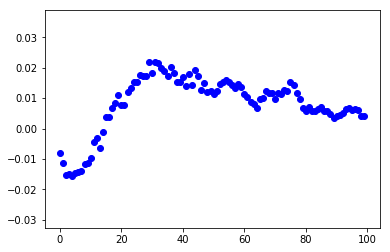

In [14]:
plt.scatter(range(num_periods), (coordination-coordination2)/num_reps, c = "blue")

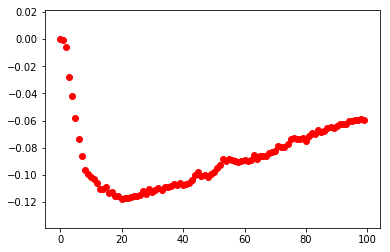

In [15]:
plt.scatter(range(num_periods), (coordination-coordination3)/num_reps, c = "red")

## 5. Exercise
What would happen if you change the minimum and maximum value of the Bernoulli bandits? Should the percentage of agreement change? 